Device is cpu
Start training


<IPython.core.display.Javascript object>


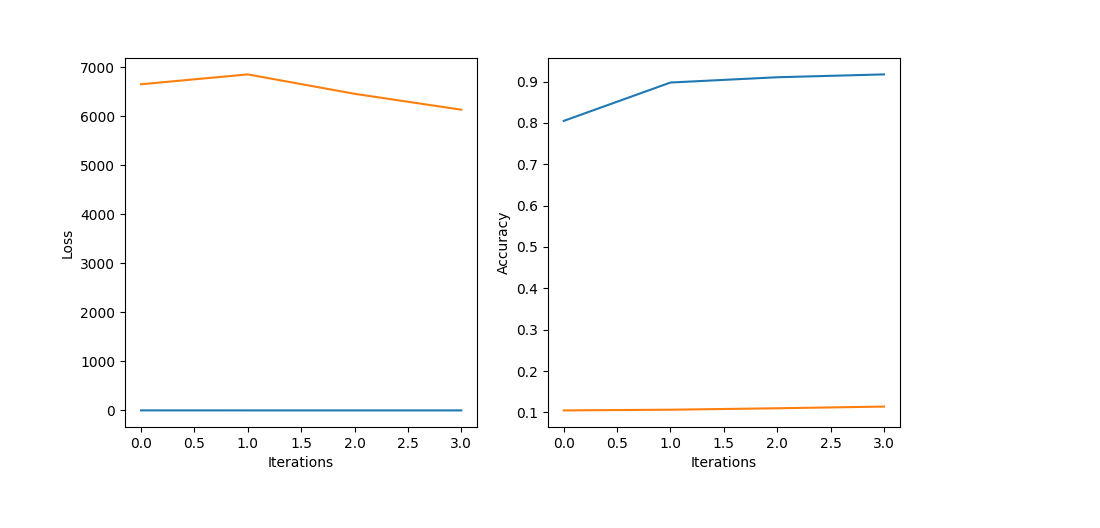

EPOCH1
ADAM_TRAIN_Loss: 0.7478, TRAIN_ACC: 0.8049
GWDC_TRAIN_Loss: 6655.3327, TRAIN_ACC: 0.1048
ADAM_TEST_Loss: 0.3732, TEST_ACC: 0.8970
GWDC_TEST_Loss: 7178.9678, TEST_ACC: 0.1035
EPOCH2
ADAM_TRAIN_Loss: 0.3537, TRAIN_ACC: 0.8976
GWDC_TRAIN_Loss: 6856.5424, TRAIN_ACC: 0.1065
ADAM_TEST_Loss: 0.3074, TEST_ACC: 0.9129
GWDC_TEST_Loss: 6725.6919, TEST_ACC: 0.1079
EPOCH3
ADAM_TRAIN_Loss: 0.3093, TRAIN_ACC: 0.9104
GWDC_TRAIN_Loss: 6460.6651, TRAIN_ACC: 0.1100
ADAM_TEST_Loss: 0.2811, TEST_ACC: 0.9185
GWDC_TEST_Loss: 6375.7451, TEST_ACC: 0.1132
EPOCH4
ADAM_TRAIN_Loss: 0.2843, TRAIN_ACC: 0.9173
GWDC_TRAIN_Loss: 6136.3134, TRAIN_ACC: 0.1141
ADAM_TEST_Loss: 0.2609, TEST_ACC: 0.9250
GWDC_TEST_Loss: 6074.3901, TEST_ACC: 0.1164


In [ ]:
%matplotlib notebook
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import DataLoader
from GWDC2 import GWDC2
from ADAM import ADAM
import os
import math
import numpy as np
from plot import dynamicplot

EPOCH = 50
BATCH_SIZE = 20
LR = 0.01
ROOT = "./data/mnist"
DOWNLOAD_MNIST = False
if not os.path.exists(ROOT):
    DOWNLOAD_MNIST = True
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Device is '+torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device('cpu')
    print('Device is cpu')

#设置一个转换的集合，先把数据转换到tensor，再归一化为均值.5，标准差.5的正态分布
trans=torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),#ToTensor方法把[0,255]变成[0,1]
        torchvision.transforms.Normalize([0.5],[0.5])#mean(均值)，std（标准差standard deviation）
    ]
)


#dataloader
train_data=torchvision.datasets.MNIST(
    root=ROOT,
    train=True,
    transform=trans,
    download=DOWNLOAD_MNIST
)

train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
 
test_data=torchvision.datasets.MNIST(
    root=ROOT,
    train=False,
    transform=trans,
    download=DOWNLOAD_MNIST
)
test_loader=DataLoader(test_data,batch_size=len(test_data),shuffle=False)
 
#NN 单层感知机
#net=torch.nn.Sequential(
#    nn.Linear(28*28,30),
#    nn.ReLU()
#    nn.Linear(30,10)
#)

#NN 2层感知机
ADAMnet=torch.nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,30),
    nn.ReLU(),
    nn.Linear(30,10)
)
GWDCnet=torch.nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,30),
    nn.ReLU(),
    nn.Linear(30,10)
)
ADAMnet = ADAMnet.to(DEVICE)
GWDCnet = GWDCnet.to(DEVICE)
#nets = [ADAMnet, DWGCnet]
#net.to(DEVICE)

loss_function=nn.CrossEntropyLoss()
#optimizer=torch.optim.SGD(net.parameters(),lr=LR)
optimADAM = ADAM(ADAMnet.parameters())

optimGWDC = GWDC2(GWDCnet.parameters())
#optimizers = [optimADAM, optimGWDC]
print("Start training")
DP = dynamicplot()
DP.plotdefine()
for ep in range(EPOCH):
    batch_num = 0
    train_loss1 = 0
    train_loss2 = 0
    test_batch_num = 0
    test_loss1 = 0
    test_loss2 = 0
    train1_num_correct=0
    train2_num_correct=0
    test1_num_correct=0
    test2_num_correct=0
    for data in train_loader:#对于训练集的每一个batch
        
        img,label=data
        img = img.view(img.size(0), -1)#拉平图片成一维向量
         
        
        img=img.to(DEVICE)
        label=label.to(DEVICE)
 
        out1=ADAMnet(img)
        out2=GWDCnet(img)
        loss1=loss_function(out1,label)
        loss2=loss_function(out2,label)
        optimADAM.zero_grad()#梯度归零
        optimGWDC.zero_grad()
        loss1.backward()#反向传播
        loss2.backward()
        optimADAM.step()#更新梯度
        optimGWDC.step()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        batch_num += 1
        _,prediction1=torch.max(out1,1)
        _,prediction2=torch.max(out2,1)
        train1_num_correct+=(prediction1==label).sum()
        train2_num_correct+=(prediction2==label).sum()
    print('EPOCH%d'%(ep+1))
    train1_accuracy=train1_num_correct.cpu().numpy()/len(train_data)
    train2_accuracy=train2_num_correct.cpu().numpy()/len(train_data)
    print('ADAM_TRAIN_Loss: %.4f, TRAIN_ACC: %.4f'%(train_loss1/batch_num,train1_accuracy))
    print('GWDC_TRAIN_Loss: %.4f, TRAIN_ACC: %.4f'%(train_loss2/batch_num,train2_accuracy))
    
    for data in test_loader:
        img,label=data
        img = img.view(img.size(0), -1)
 
        img=img.to(DEVICE)
        label=label.to(DEVICE)
 
        out1=ADAMnet(img)
        out2=GWDCnet(img)
        loss1=loss_function(out1,label)
        loss2=loss_function(out2,label)
        test_loss1 += loss1.item()
        test_loss2 += loss2.item()
        test_batch_num += 1
        _,prediction1=torch.max(out1,1)
        _,prediction2=torch.max(out2,1)
        #torch.max()返回两个结果，
        # 第一个是最大值，第二个是对应的索引值；
        # 第二个参数 0 代表按列取最大值并返回对应的行索引值，1 代表按行取最大值并返回对应的列索引值。
        test1_num_correct+=(prediction1==label).sum()#找出预测和真实值相同的数量，也就是以预测正确的数量
        test2_num_correct+=(prediction2==label).sum()
    accuracy1=test1_num_correct.cpu().numpy()/len(test_data)
    accuracy2=test2_num_correct.cpu().numpy()/len(test_data)
    print("ADAM_TEST_Loss: %.4f, TEST_ACC: %.4f"%(test_loss1/test_batch_num,accuracy1))
    print("GWDC_TEST_Loss: %.4f, TEST_ACC: %.4f"%(test_loss2/test_batch_num,accuracy2))
    DP.showplot(train_loss1/batch_num,train1_accuracy,train_loss2/batch_num,train2_accuracy)
#test-push!